# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<div class="alert alert-block alert-warning">
<b>Совет:</b> Важно чтобы в проектах было подробное описание: когда потенциальные работодатели будут смотреть твой проект в портфолио, им нужно будет понимать задачу, чтобы можно было оценить её решение. Вот что можно добавить:
    
* Описание целей и задачи проекта
* Описание данных
* План работы
</div>

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

<div class="alert alert-block alert-success">
<b>Успех:</b> Правильное решение — выделять отдельную ячейку в начале проекта под подключение библиотек и настройки. Tак код легче поддерживать 👌
</div>

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/определение стоимости автомобилей/autos.csv')
except:
  data = pd.read_csv('/datasets/autos.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# изучим данные
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
#переведем все названия столбцов в нижный регистр
data.columns = data.columns.str.lower()

In [ ]:
#переведем столбцы в змеиный регистр
data = data.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'notrepaired':'not_repaired', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

<div class="alert alert-block alert-success">
<b>Успех:</b> Работать с такими названиями гораздо удобнее) Посмотри на такой вариант ниже. Здесь мы используем регулярные выражения

Полезная <a href='https://habr.com/ru/post/545150/'>статья</a> про regex для начала
    
Этот блогер хорошо объясняет в своем <a href='https://www.youtube.com/watch?v=sHw5hLYFaIw&t=247s'>видео</a>
</div>

```python
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
```

In [ ]:
#найдем число уникальных значений в стобце "количество фотографий"
data.number_of_pictures.value_counts()

0    354369
Name: number_of_pictures, dtype: int64

Удалим этот столбец, а также другие неинформативные столбцы

In [ ]:
#удалим столбцы, которые нам не понадобятся
data = data.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

<div class="alert alert-block alert-success">
<b>Успех:</b> Правильно эти столбцы не пригодятся для обучения моделей 👍
</div>

In [ ]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [ ]:
# найдем количество пропусков
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
not_repaired         71154
dtype: int64

Найдем долю пропусков в столбцах, содержащих пропуски

In [ ]:
print('Доля пропусков в vehicle_type: {:.2%}'.format(data['vehicle_type'].isna().mean()))

Доля пропусков в vehicle_type: 10.58%


In [ ]:
print('Доля пропусков в gearbox: {:.2%}'.format(data['gearbox'].isna().mean()))

Доля пропусков в gearbox: 5.60%


In [ ]:
print('Доля пропусков в model: {:.2%}'.format(data['model'].isna().mean()))

Доля пропусков в model: 5.56%


In [ ]:
print('Доля пропусков в fuel_type: {:.2%}'.format(data['fuel_type'].isna().mean()))

Доля пропусков в fuel_type: 9.28%


In [ ]:
print('Доля пропусков в not_repaired: {:.2%}'.format(data['not_repaired'].isna().mean()))

Доля пропусков в not_repaired: 20.08%


In [ ]:
data.not_repaired.value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

In [ ]:
# выведем столбцы с пропусками
data[data['vehicle_type'].isna() & data['fuel_type'].isna() & data['model'].isna()&data['not_repaired'].isna()&data['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


In [ ]:
# удалими строки так, чтобы из 5 столбцов c пропусками, удалились 3 с пропусками из этого списка
data = data.dropna(subset=['vehicle_type', 'fuel_type', 'model', 'not_repaired','gearbox'], thresh = 3)

In [ ]:
data.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In [ ]:
# найдем уникальные значения столбца "тип топлива"
data.fuel_type.value_counts()

petrol      213687
gasoline     97814
lpg           5254
cng            561
hybrid         230
other          169
electric        86
Name: fuel_type, dtype: int64

In [ ]:
# переименуем gasoline в petrol, поскольку оба означают "бензин"
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')

In [ ]:
# заполним пропуски значением other.
data.fuel_type.fillna('other', inplace=True)

In [ ]:
# найдем уникальные значения в столбце "тип кузова"
data.vehicle_type.value_counts()

sedan          90870
small          79059
wagon          64683
bus            28570
convertible    20010
coupe          15995
suv            11896
other           3136
Name: vehicle_type, dtype: int64

In [ ]:
# поскольку нет возможности узнать тип кузова, заменим пропуски в этом столбце на other
data.vehicle_type.fillna('other', inplace=True)

In [ ]:
# найдем уникальные значения стобца "коробка передач"
data.gearbox.value_counts()

manual    262289
auto       65098
Name: gearbox, dtype: int64

In [ ]:
# заполним пропуски значением "unknown"
data.gearbox.fillna('unknown', inplace=True)

In [ ]:
# в столбце "модель" и "не был в ремонте" тоже заполним пропуски на unknown
data.model.fillna('unknown', inplace=True)

In [ ]:
data.not_repaired.fillna('unknown', inplace=True)

In [ ]:
#проверим пропуски
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

In [ ]:
# найдем уникальные значения в столбце "год регистрации"
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989,
       2015, 1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1965, 1970, 1945, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961,
       1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941,
       1962, 1929, 1957, 1940, 1949, 1937, 1951, 1953, 2019, 2900, 6000,
       1400, 1950, 4000, 1948, 1952, 1200, 1932, 3700, 5000, 1942, 1935,
       1933, 1936, 6500, 1923, 1930, 1943, 1934, 1938, 9000, 1000, 1919,
       1928, 1931, 1602, 1927, 1947, 1946, 7500, 1944, 1600])

поскольку наши данные на 2016 год, удалим все строки с годом после 2016, и, поскольку автомобили до 1900 года это скорее всего аномалии, удалим их тоже

In [ ]:
df = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1900)]

In [ ]:
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 2016, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015, 1985,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1965, 1970,
       1945, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960, 1966,
       1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941, 1962, 1929,
       1957, 1940, 1949, 1937, 1951, 1953, 1950, 1948, 1952, 1932, 1942,
       1935, 1933, 1936, 1923, 1930, 1943, 1934, 1938, 1919, 1928, 1931,
       1927, 1947, 1946, 1944])

In [ ]:
# выведем данные
df.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,other,volkswagen,unknown


In [ ]:
# найдем уникальные значения в столбце "мощность"
df.power.value_counts()

0       27732
75      22234
60      14739
150     13922
101     12496
        ...  
851         1
1339        1
1056        1
1999        1
1241        1
Name: power, Length: 691, dtype: int64

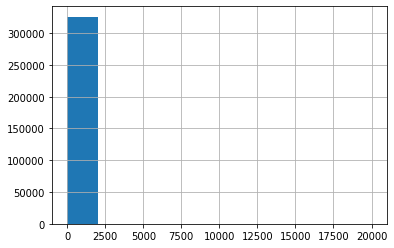

In [ ]:
df.power.hist()

In [ ]:
# удалим аномалии - скорость больше 700 лошадиных сил
df = df.loc[df['power'] <= 700]


In [ ]:
# заменим нули медианой 
power_med = df['power'].median()

In [ ]:
df['power'] = df['power'].replace(0, power_med)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


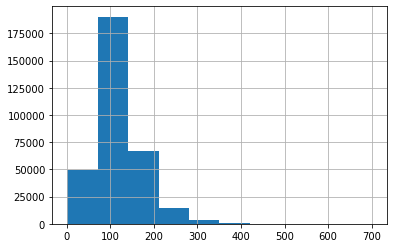

In [ ]:
df.power.hist()

In [ ]:
# проверим на аномалии значения столбца "цена"
df.price.value_counts()

0        7565
500      5061
1500     4863
1200     4127
2500     4085
         ... 
5377        1
3021        1
1368        1
11080       1
10985       1
Name: price, Length: 3651, dtype: int64

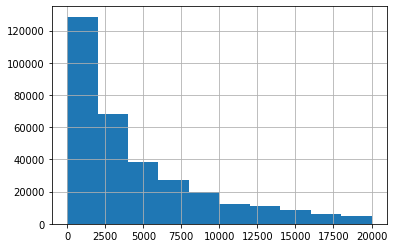

In [ ]:
df.price.hist()

In [ ]:
# нулевых значений не так много. удалим их 
df = df.loc[df['price'] > 0]

In [ ]:
df.price.value_counts()

500      5061
1500     4863
1200     4127
2500     4085
1000     4050
         ... 
17159       1
3089        1
6235        1
1379        1
10985       1
Name: price, Length: 3650, dtype: int64

In [ ]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,other,1993,manual,105,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


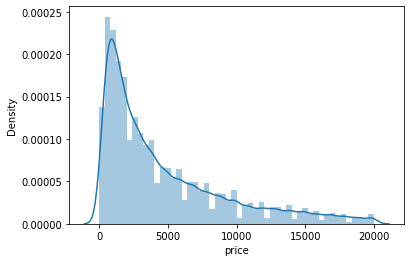

In [ ]:
sns_plot = sns.distplot(df['price'])
fig = sns_plot.get_figure()

In [ ]:
# проверим данные на дубликаты
df.duplicated().sum()

42531

In [ ]:
#удалим дубликаты(с удалением старых индексов и формированием новых)
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()#проверим

0

In [ ]:
# #переведем категориальные значения столбцов в количественные
# data_ohe = pd.get_dummies(df, drop_first=True)
# data_ohe.head()

<div class="alert alert-block alert-success">
<b>Успех:</b> Для линейных моделей OHE отлично подойдет 👍 Для других стоит использовать порядковое кодирование
</div>

## Вывод 1.

В этом разделе мы произвели предобработку данных. На входе мы получили таблицу с более чем 350 тыс. строк и 16 столбцами. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий. Удалили дубликаты и перевели категориальные значения столбцов в количественные. В итоге у нас образовалась таблица в 281 тыс. строк и 309 столбцов.

<div class="alert alert-block alert-success">
<b>Успех:</b> С аномальными значениями и пропусками успешно справились 👍
</div>

## Обучение моделей

In [ ]:
#переведем категориальные значения столбцов в количественные
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,480,1993,105,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#разделим выборки на обучающую и тестовую
target_ohe = data_ohe['price']
features_ohe = data_ohe.drop('price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target_ohe, test_size=0.25, random_state=12345) 


print(features_train_ohe.shape)
print(features_test_ohe.shape)

(206619, 308)
(68874, 308)


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные поделены верно, пропорции выбраны адекватные 👍
</div>

In [ ]:
list(data_ohe.columns.values)

['price',
 'registration_year',
 'power',
 'kilometer',
 'vehicle_type_convertible',
 'vehicle_type_coupe',
 'vehicle_type_other',
 'vehicle_type_sedan',
 'vehicle_type_small',
 'vehicle_type_suv',
 'vehicle_type_wagon',
 'gearbox_manual',
 'gearbox_unknown',
 'model_145',
 'model_147',
 'model_156',
 'model_159',
 'model_1_reihe',
 'model_1er',
 'model_200',
 'model_2_reihe',
 'model_300c',
 'model_3_reihe',
 'model_3er',
 'model_4_reihe',
 'model_500',
 'model_5_reihe',
 'model_5er',
 'model_601',
 'model_6_reihe',
 'model_6er',
 'model_7er',
 'model_80',
 'model_850',
 'model_90',
 'model_900',
 'model_9000',
 'model_911',
 'model_a1',
 'model_a2',
 'model_a3',
 'model_a4',
 'model_a5',
 'model_a6',
 'model_a8',
 'model_a_klasse',
 'model_accord',
 'model_agila',
 'model_alhambra',
 'model_almera',
 'model_altea',
 'model_amarok',
 'model_antara',
 'model_arosa',
 'model_astra',
 'model_auris',
 'model_avensis',
 'model_aveo',
 'model_aygo',
 'model_b_klasse',
 'model_b_max',
 'mode

In [ ]:
numeric = list(data_ohe)
numeric.remove('price')
print (numeric)

['registration_year', 'power', 'kilometer', 'vehicle_type_convertible', 'vehicle_type_coupe', 'vehicle_type_other', 'vehicle_type_sedan', 'vehicle_type_small', 'vehicle_type_suv', 'vehicle_type_wagon', 'gearbox_manual', 'gearbox_unknown', 'model_145', 'model_147', 'model_156', 'model_159', 'model_1_reihe', 'model_1er', 'model_200', 'model_2_reihe', 'model_300c', 'model_3_reihe', 'model_3er', 'model_4_reihe', 'model_500', 'model_5_reihe', 'model_5er', 'model_601', 'model_6_reihe', 'model_6er', 'model_7er', 'model_80', 'model_850', 'model_90', 'model_900', 'model_9000', 'model_911', 'model_a1', 'model_a2', 'model_a3', 'model_a4', 'model_a5', 'model_a6', 'model_a8', 'model_a_klasse', 'model_accord', 'model_agila', 'model_alhambra', 'model_almera', 'model_altea', 'model_amarok', 'model_antara', 'model_arosa', 'model_astra', 'model_auris', 'model_avensis', 'model_aveo', 'model_aygo', 'model_b_klasse', 'model_b_max', 'model_beetle', 'model_berlingo', 'model_bora', 'model_boxster', 'model_bra

In [ ]:
#масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [ ]:
features_train_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
125528,0.053151,-0.773714,-0.062361,-0.262357,-0.232208,-0.222159,-0.61591,1.801739,-0.198965,-0.496005,...,-0.127694,-0.082714,-0.048002,-0.08398,-0.121955,-0.035083,-0.502209,-0.100597,-0.440687,-0.349812
56964,-1.266390,0.372860,0.601952,-0.262357,4.306487,-0.222159,-0.61591,-0.555019,-0.198965,-0.496005,...,-0.127694,-0.082714,-0.048002,-0.08398,-0.121955,-0.035083,-0.502209,-0.100597,-0.440687,-0.349812
76197,0.639613,1.978064,0.601952,-0.262357,-0.232208,-0.222159,-0.61591,-0.555019,5.026000,-0.496005,...,-0.127694,-0.082714,-0.048002,-0.08398,-0.121955,-0.035083,1.991204,-0.100597,-0.440687,-0.349812
154204,1.812539,-1.155905,-3.251064,-0.262357,-0.232208,-0.222159,-0.61591,1.801739,-0.198965,-0.496005,...,-0.127694,-0.082714,-0.048002,-0.08398,-0.121955,-0.035083,1.991204,-0.100597,-0.440687,-0.349812
272240,-0.386696,-0.582618,0.601952,-0.262357,-0.232208,-0.222159,-0.61591,-0.555019,-0.198965,2.016107,...,-0.127694,-0.082714,-0.048002,-0.08398,-0.121955,-0.035083,-0.502209,-0.100597,-0.440687,2.858682


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, признаки масштабированы 👍 Не забыли, что fit нужно делать только на train выборке
</div>

##2.1 Модель линейной регрессии

In [ ]:
# обучим модель линейной регрессии
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
#построим предсказания на тренировочной выборке
predictions_train_ohe = model.predict(features_train_ohe)
#найдем корень из квадратичной средней ошибки (RMSE)
rmse = mean_squared_error(target_train_ohe, predictions_train_ohe)**0.5
print(rmse)

2730.9839974535544


##2.2 Модель решающего дерева

In [ ]:
# закодируем признаки с помощью порядкового кодирования
enc = OrdinalEncoder()
enc.fit(df[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'not_repaired']])
df[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'not_repaired']] = enc.transform(df[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'not_repaired']])

In [ ]:
#разделим выборки на обучающую и тестовую
target_oe = df['price']
features_oe = df.drop('price', axis=1)
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, target_oe, test_size=0.25, random_state=12345) 


print(features_train_oe.shape)
print(features_test_oe.shape)

(206619, 9)
(68874, 9)


In [ ]:
# построим модель для решающего дерева и найдем наилучшие гиперпараметры
# найдем лучшие гиперпараметры для глубины дерева
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(features_train_oe, target_train_oe)
    predictions_train_oe = model.predict(features_train_oe)
    rmse = mean_squared_error(target_train_oe, predictions_train_oe)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse)
    print('')
print()

Глубина: 3
RMSE для решающего дерева: 2974.488726687611

Глубина: 6
RMSE для решающего дерева: 2347.9315992693814

Глубина: 9
RMSE для решающего дерева: 2044.5694673941925

Глубина: 12
RMSE для решающего дерева: 1752.4703490376614

Глубина: 15
RMSE для решающего дерева: 1445.218726403213

Глубина: 18
RMSE для решающего дерева: 1160.511941004421




<div class="alert alert-block alert-danger">
<b>Замечание:</b> Для моделей, основанных на деревьях решений, лучше использовать порядковое кодирование (OrdinalEncoder). Это должно ускорить их работу
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> исправила, использовав порядковое кодирование
</div>

Модель склонна к переобучению. Стоит ограничить глубину дерева, например, значением 9.

##2.3 Модель случайного леса

In [ ]:
%%time
for est in [100, 500, 1000]:
    model = RandomForestRegressor(random_state=12345, 
                                   n_estimators=est, 
                                   max_depth=9)
    model.fit(features_train_oe, target_train_oe)
    predictions_train_oe = model.predict(features_train_oe)
    rmse = mean_squared_error(target_train_oe, predictions_train_oe)**0.5
    print('Количество деревьев:', est)
    print('RMSE для случайного леса:', rmse)
    print('')
print()

Количество деревьев: 100
RMSE для случайного леса: 1969.6486605801845

Количество деревьев: 500
RMSE для случайного леса: 1969.7510142660935

Количество деревьев: 1000
RMSE для случайного леса: 1969.239500874075


CPU times: user 9min 52s, sys: 1.08 s, total: 9min 53s
Wall time: 10min 4s


Разница для 100, 500 и 1000 оказалась небольшой. Гораздо большее значение имеет глубина.

##2.4 LightGBM

Установим LightGBM и построим модель

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# check lightgbm version
import lightgbm
print(lightgbm.__version__)

2.2.3


In [ ]:
# выделим признаки и целевой признак
target = df['price']
features = df.drop('price', axis=1)

# переведем категориальные признаки в тип category, который требуется для LightGBM
for c in features.columns:
  col_type = features[c].dtype
  if col_type == 'object':
    features[c] = features[c].astype('category')

#разделим выборки на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 

# проверим размер выборок
print(features_train.shape)
print(features_test.shape)

(206619, 9)
(68874, 9)


In [ ]:
# построим модель без подбора гиперпараметров
model = lgb.LGBMRegressor(random_state=12345)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
rmse = mean_squared_error(target_train, predictions_train)**0.5
print(rmse)

1618.9836373245057


Найдем наилучшие гиперпараметры для LightGBM

In [ ]:
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

In [ ]:
'''я не запускаю GridSearch повторно, поскольку очень долго считает'''
model = lgb.LGBMRegressor(random_state=12345)

tuning_model=GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)


Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV 1/3] END n_estimators=100, num_leaves=20;, score=-1663.643 total time=   3.6s
[CV 2/3] END n_estimators=100, num_leaves=20;, score=-1686.140 total time=   1.9s
[CV 3/3] END n_estimators=100, num_leaves=20;, score=-1675.559 total time=   1.6s
[CV 1/3] END n_estimators=100, num_leaves=40;, score=-1620.572 total time=   1.9s
[CV 2/3] END n_estimators=100, num_leaves=40;, score=-1642.571 total time=   1.9s
[CV 3/3] END n_estimators=100, num_leaves=40;, score=-1630.839 total time=   1.9s
[CV 1/3] END n_estimators=100, num_leaves=60;, score=-1595.915 total time=   2.2s
[CV 2/3] END n_estimators=100, num_leaves=60;, score=-1616.485 total time=   2.2s
[CV 3/3] END n_estimators=100, num_leaves=60;, score=-1607.147 total time=   2.1s
[CV 1/3] END n_estimators=100, num_leaves=80;, score=-1582.735 total time=   2.3s
[CV 2/3] END n_estimators=100, num_leaves=80;, score=-1602.011 total time=   2.3s
[CV 3/3] END n_estimators=100, num_l

{'n_estimators': 500, 'num_leaves': 180}

1545.9219520601557

##Вывод 2.

В этом разделе мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами 'n_estimators': 500, 'num_leaves': 180 дает наименьшее значение rmse: 1545.92.

## Анализ моделей

##3.1 Модель линейной регрессии

In [ ]:
%%time
# найдем время обучения модели линейной регрессии
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)


CPU times: user 11.4 s, sys: 1.42 s, total: 12.8 s
Wall time: 7.75 s


In [ ]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train_ohe = model.predict(features_train_ohe)


CPU times: user 135 ms, sys: 1.95 ms, total: 137 ms
Wall time: 97.3 ms


##3.2 Модель решающего дерева

In [ ]:
%%time
# найдем время обучения модели решающего дерева
model = DecisionTreeRegressor(random_state=12345, max_depth=9)
model.fit(features_train_oe, target_train_oe)

CPU times: user 704 ms, sys: 972 µs, total: 705 ms
Wall time: 724 ms


In [ ]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train_oe = model.predict(features_train_oe)

CPU times: user 32.3 ms, sys: 0 ns, total: 32.3 ms
Wall time: 31.3 ms


##3.3 Модель случайного леса

In [ ]:
%%time
# обучим модель случайного леса
model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=1000)
model.fit(features_train_oe, target_train_oe)

CPU times: user 5min 54s, sys: 554 ms, total: 5min 55s
Wall time: 6min


In [ ]:
%%time
#построим предсказания на тренировочной выборке
predictions_train_oe = model.predict(features_train_oe)

CPU times: user 20.4 s, sys: 73.7 ms, total: 20.4 s
Wall time: 21.9 s


##3.4 Модель LightGBM

In [ ]:
# найдем время обучения LightGBM
%%time
model = lgb.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=180)
model.fit(features_train, target_train)

CPU times: user 16.7 s, sys: 428 ms, total: 17.1 s
Wall time: 8.83 s


In [ ]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train = model.predict(features_train)

CPU times: user 18.3 s, sys: 28.2 ms, total: 18.3 s
Wall time: 9.5 s


In [ ]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

1585.7834436543199


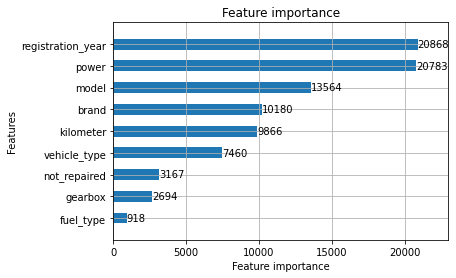

In [ ]:
# посмотрим на то, какие признаки влияют больше всего
lgb.plot_importance(model, height=.5)

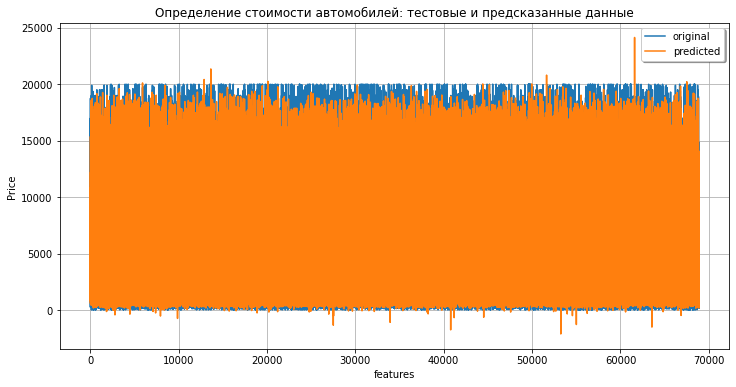

In [ ]:
# visualizing in a plot
x_ax = range(len(target_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, target_test, label="original")
plt.plot(x_ax, predictions_test, label="predicted")
plt.title("Определение стоимости автомобилей: тестовые и предсказанные данные")
plt.xlabel('features')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

##Вывод 3.

In [1]:
tabledata = [["линейная регрессия: обучение", "12,8 s", "7,75 s"],
             ["линейная регрессия: предсказание", "137 ms", "93,7 ms"],
         ["решающее дерево: обучение", "705 ms", "725 ms"],
         ["решающее дерево: предсказание", "32,3 ms", "31,3 ms"],
         ["случайный лес: обучение", "5min 55s", "6min"],
         ["случайный лес: предсказание", "20.4 s", "21,9 s"],
         ["LightGBM: обучение", "17.1 s", "8,83 s"],
         ["LightGBM: предсказание", "18.3 s", "9,5 s"]]
df= pd.DataFrame(tabledata, columns=["модель","CPU-times", "Wall time"])
df = df.set_index('модель')
df.index.names = [None]
df

NameError: ignored

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что для сравнения моделей заносишь их в общий датафрейм 👍
</div>

Дольше всего учится модель случайного леса: 6 мин. 
Модель LightGBM имеет приемлемую скорость обучения и предсказания (в пределах 20 сек.) и при этом самую низкую RMSE из всех моделей: на тестовой выборке результат 1585.78. 

## Общий вывод

1. На входе мы получили таблицу с более чем 350 тыс. строк и 16 столбцами. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий. Удалили дубликаты. 

2. Для модели линейной регрессии перевели категориальные значения столбцов в количественные. В итоге у нас образовалась таблица в 281 тыс. строк и 309 столбцов. Для моделец решающего дерева и случайного леса применили порядковое кодирование, в итоге для них количесвто столбцов не изменилось, а подбор гиперпараметров стал быстрее. Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами 'n_estimators': 500, 'num_leaves': 180 дает наименьшее значение rmse: 1545.92.

3. Мы проанализировали все модели и обнаружили, что дольше всего учится модель случайного леса: 6 мин. Модель LightGBM имеет приемлемую скорость обучения и предсказания (в пределах 20 сек.) и при этом самую низкую RMSE из всех моделей: на тестовой выборке результат 1585.78. 

Исходя из требований заказчика по скорости обучения, придсказания и качества модели, рекомендуем модель LightGBM, поскольку она имеет самые оптимальные характеристики.

<div class="alert alert-block alert-danger">
<b>Замечание:</b> Нужно порекомендовать заказчику одну модель на основе его критериев
</div>

<div class="alert alert-block alert-danger">
<b>Замечание:</b> Не забывай про финальный вывод в конце проекта)
</div>

# <font color='orange'>Общее впечатление</font>
* Этот проект выполнен очень хорошо
* Видно, что приложено много усилий
* Молодец, что структурируешь ноутбук, приятно проверять такие работы
* У тебя чистый и лаконичный код
* Мне было интересно читать твои промежуточные выводы
* Твой уровень подачи материала находится на высоком уровне
* Исправь, пожалуйста, мои замечания. Затем отправляй на повторную проверку
* Жду новую версию проекта 👋

<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены следующие изменения: добавлено кодирование признаков для моделей деревьев, исправлены результаты, добавлен общий вывод и рекомендации для заказчика
</div>